# CheXScan DenseNet-121 Model

## Libraries

In [21]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image

import time

print("Imports completed successfully.")

Imports completed successfully.


## Run this code if you're using Colab

In [22]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Transform functions for data augmentation and normalization

You can further adjust these parameters if needed to achieve the desired balance between augmentation and maintaining image quality.

#### train_transform and test_transform

    Apply transformations to the input image for training data.

    Parameters:
        image (PIL.Image): Input image to be transformed.

    Returns:
        transformed_image (Tensor): Transformed image in tensor format.

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

In [24]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

## Dataset Summary

In [25]:
data_dir = r"C:\Users\Cipriano\Desktop\chexscan/data"
train_data_dir = os.path.join(data_dir, 'train_data')
test_data_dir = os.path.join(data_dir, 'test_data')

In [26]:
def count_images_in_subdirectories(directory):
    subdirectories = os.listdir(directory)
    counts = {}
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        count = sum(len(files) for _, _, files in os.walk(subdir_path))
        counts[subdir] = count
    return counts

In [27]:
train_counts = count_images_in_subdirectories(train_data_dir)
test_counts = count_images_in_subdirectories(test_data_dir)

print("Number of images in each subdirectory of training data:")
for subdir, count in train_counts.items():
    print(f"{subdir}: {count}")

print("\nNumber of images in each subdirectory of testing data:")
for subdir, count in test_counts.items():
    print(f"{subdir}: {count}")

Number of images in each subdirectory of training data:
Normal: 800
Pneumonia: 800
Tuberculosis: 800

Number of images in each subdirectory of testing data:
Normal: 200
Pneumonia: 200
Tuberculosis: 200


## Define datasets (Online)

In [28]:
# data_dir = '/content/drive/My Drive/THESIS/Datasets/Mary/'
# train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
# test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define datasets (Local)

In [29]:
data_dir = r"C:\Users\Cipriano\Desktop\chexscan/data"
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define data loaders

In [30]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Visualizes training data

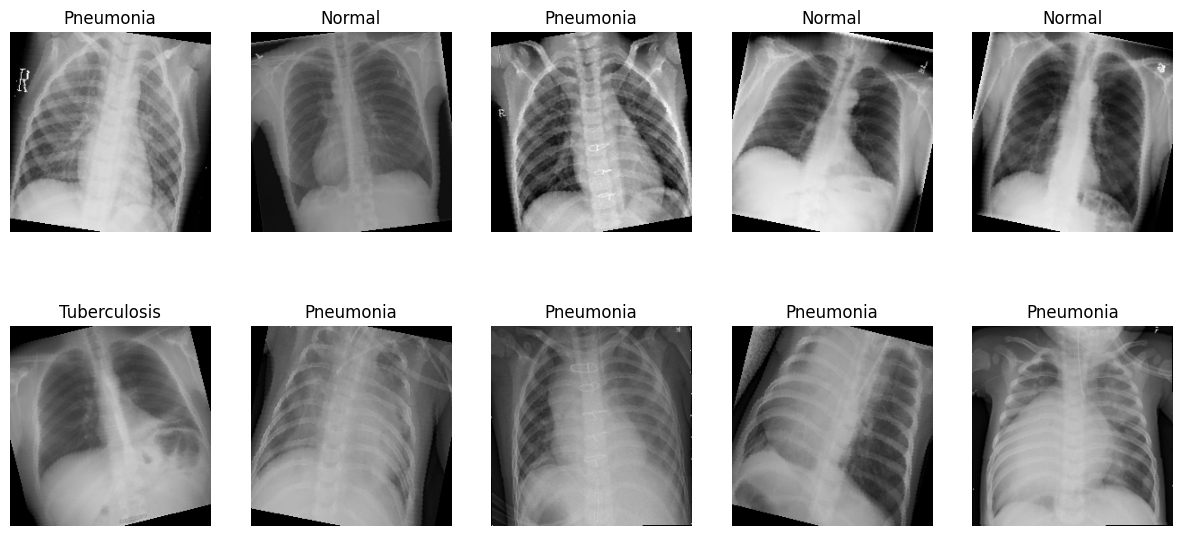

In [31]:
def visualize_training_data(loader):
    
    """
    Visualizes a batch of training images along with their corresponding labels.

    Parameters:
        loader (DataLoader): DataLoader containing the training dataset.

    Returns:
        None
    """
    
    classes = loader.dataset.classes
    class_names = {i: classes[i] for i in range(len(classes))}
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.show()

visualize_training_data(train_loader)

## Define DenseNet-121 model

In [32]:
model = models.densenet121(pretrained=True)

In [33]:
for param in model.parameters():
    param.requires_grad = False

In [34]:
# Modify the last layer of the classifier
num_classes = 3  # Replace 3 with the number of classes in your dataset
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

## Define loss function and optimizer

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Move model to GPU if available

In [1]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

## DenseNet-121 Model Training

In [37]:
num_epochs = 30
train_losses = []
val_losses = []
val_accuracies = []

In [38]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the frequency of saving checkpoints
save_interval = 5  # Save checkpoint every 5 epochs, for example

# Define variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 3  # Number of consecutive epochs with val accuracy >= 98% to stop training

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_data)
    train_accuracy = correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_data)
    val_accuracy = correct / total
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

    # Save checkpoint
    if (epoch + 1) % save_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }, checkpoint_path)

    # Check early stopping condition
    if val_accuracy >= 0.98:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_threshold:
            print("Validation accuracy reached 98% or above for 3 consecutive epochs. Training will stop.")
            break
    else:
        early_stopping_counter = 0

print("Training complete.")

## Classification Report

In [ ]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
class_names = test_data.classes
print(classification_report(true_labels, predictions, target_names=class_names))

NameError: name 'model' is not defined

## Performance Visualization

In [ ]:
metrics_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': [acc * 100 for acc in val_accuracies],  # Corrected variable name
    'Val Loss': val_losses,
    'Val Accuracy': [acc * 100 for acc in val_accuracies]
})

## Validation Accuracy

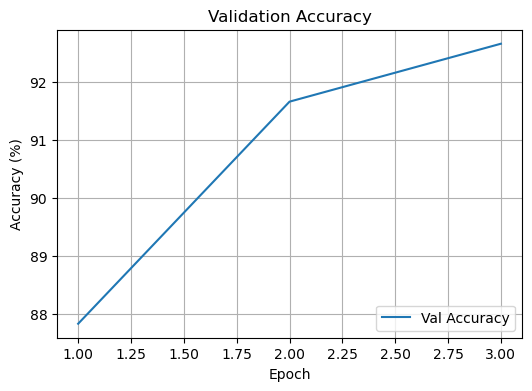

In [ ]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=metrics_df, x='Epoch', y='Val Accuracy', label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Training and Validation Loss

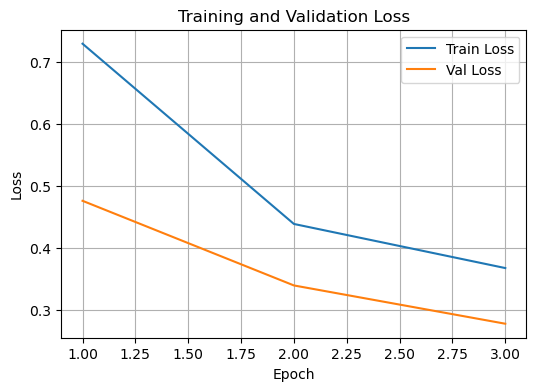

In [ ]:
plt.figure(figsize=(6, 4))  # Adjust size here
sns.lineplot(data=metrics_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=metrics_df, x='Epoch', y='Val Loss', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Saving the model

In [ ]:
torch.save(model.state_dict(), 'densenet121-model.pth')

print("Model saved successfully.")